In [71]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [124]:
# numerical parameters

resolDisplay = 100 # resolution of the display for the number of point
nbPoint = 200  # Number of points

In [125]:
# parameters

R1 = 130
R2 = 0
eta = 0.9
m = 1
L = 2
n = 1
DeltaP = 5

In [126]:
def dimensionalParameter(R1, R2, eta, L, n):
    r1 = eta/(1-eta)
    r2 = r1+1
    nu = 1
    omega1 = R1 * nu / r1
    omega2 = R2 * nu / r2
    p0 = 0
    rho = 1
    beta = 2 * np.pi * n / L
    return r1, r2, nu, omega1, omega2, p0, rho, beta

In [127]:
# dimensional parameters

r1, r2, nu, omega1, omega2, p0, rho, beta = dimensionalParameter(R1, R2, eta, L, n)


In [ ]:
def chebyshev_points(n):
    return np.cos(np.linspace(0, np.pi, n))

In [ ]:
def chebyshev_matrix(n):
    xi = chebyshev_points(n)
    
    D = np.zeros((n, n))
    C = np.ones(n)
    C[0] = 2
    C[-1] = 2
    
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i, j] = C[i] * (-1)**(i + j) / (C[j] * (xi[i] - xi[j]))
            elif i == 0:
                D[i, i] = (2 * (n - 1)**2 + 1) / 6
            elif i == n - 1:
                D[i, i] = -(2 * (n - 1)**2 + 1) / 6
            else:
                D[i, i] = -xi[i] / (2 * (1 - xi[i]**2))
    
    return D, xi

In [130]:
def chebyshev_matrix_scale(n):

    D, xi = chebyshev_matrix(n)
    DScale = D * 2 / (r2 - r1)
    xiScale = ((r2 - r1) / 2) * xi + ((r1 + r2) / 2)

    return DScale, xiScale

In [ ]:
def displayXi(ArrayValue):
    
    X = np.linspace(-1, 1, resolDisplay)
    XArrayValue = chebyshev_matrix_scale(nbPoint)[1]
    YCylinderOut = np.sqrt((1 - X ** 2) * r2 ** 2)
    YCylinderIn = np.sqrt((1 - X ** 2) * r1 ** 2)
    plt.plot(r2 * X, YCylinderOut, 'k')
    plt.plot(r2 * X, -YCylinderOut, 'k')
    plt.plot(r1 * X, YCylinderIn, 'k')
    plt.plot(r1 * X, -YCylinderIn, 'k')
    plt.plot(XArrayValue ,ArrayValue / (2 * np.max(ArrayValue)), 'b')
    plt.plot([r1, r2], [0, 0], 'b')
    plt.show()

In [132]:
def UPBaseFlow(r1, r2, omega1, omega2):

    rXi = chebyshev_matrix_scale(nbPoint)[1]

    matGeometricAxial = np.array([[np.log(r1), 1],\
                                  [np.log(r2), 1]])
    
    matGeometricTangent = np.array([[r1, 1/r1],\
                                  [r2, 1/r2]])

    matBoundaryPressure = np.array([[(DeltaP * (r1 ** 2)) / (4 * L * rho * nu)], [(DeltaP * (r2 ** 2)) / (4 * L * rho * nu)]])

    matBoundarySpeed = np.array([[r1 * omega1], [r2 * omega2]])

    coeffProfilVitesseAxial = np.linalg.inv(matGeometricAxial) @ matBoundaryPressure

    coeffProfilVitesseTangent = np.linalg.inv(matGeometricTangent) @ matBoundarySpeed

    U = (coeffProfilVitesseTangent[0] * rXi) + (coeffProfilVitesseTangent[1] / rXi)

    V = - (DeltaP * (rXi ** 2)) / (4 * L * rho * nu) + (coeffProfilVitesseAxial[0] * np.log(rXi)) + coeffProfilVitesseAxial[1]

    P = p0 + (((coeffProfilVitesseTangent[0] * rXi) ** 2) / 2) + 2 * coeffProfilVitesseTangent[0] * coeffProfilVitesseTangent[1] * np.log(rXi) - (((coeffProfilVitesseTangent[1] / rXi) ** 2) / 2)

    return U, V, P

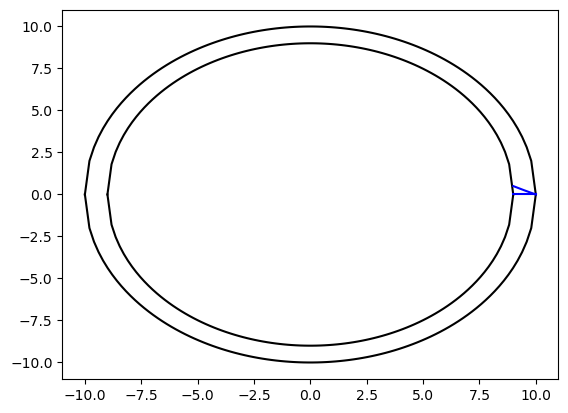

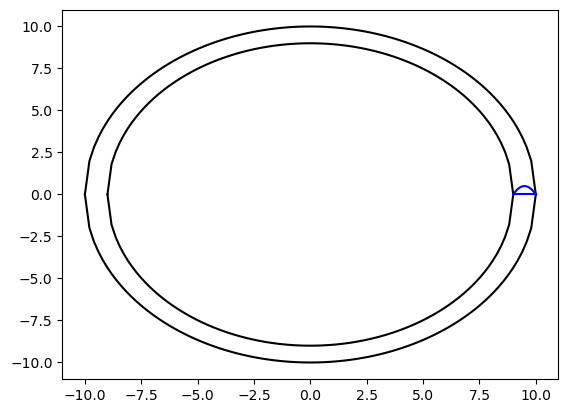

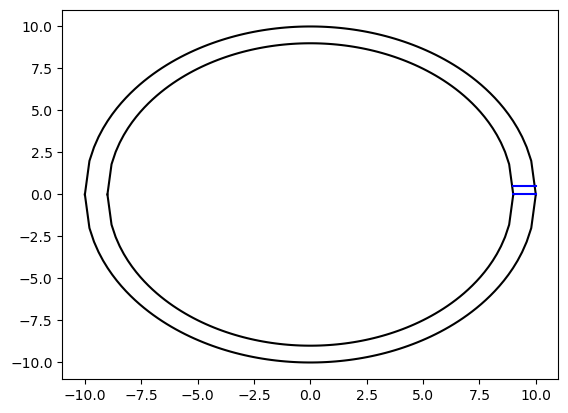

In [133]:
U, V, P = UPBaseFlow(r1, r2, omega1, omega2)

displayXi(U)
displayXi(V)
displayXi(P)

In [ ]:
def setBCs(A, B):
    # Dirichlet at R1
    A[[0, nbPoint, 2 * nbPoint], :] = 0
    A[[0, nbPoint, 2 * nbPoint], [0, nbPoint, 2 * nbPoint]] = 1
    B[[0, nbPoint, 2 * nbPoint], :] = 0
    # Dirichlet at R2
    A[[nbPoint - 1, 2 * nbPoint - 1, 3 * nbPoint - 1], :] = 0
    A[[nbPoint - 1, 2 * nbPoint - 1, 3 * nbPoint - 1], [nbPoint - 1, 2 * nbPoint - 1, 3 * nbPoint - 1]] = 1
    B[[nbPoint - 1, 2 * nbPoint - 1, 3 * nbPoint - 1], :] = 0

In [135]:
def Eig():

    D, r = chebyshev_matrix_scale(nbPoint)

    B = np.eye(4*nbPoint)
    B[3*nbPoint:4*nbPoint, 3*nbPoint:4*nbPoint] = 0 

    # Creation of the matrix A with bloc Aij, i being the line and j the column
    A11 = nu * D @ D + nu * np.diag(1/r) @ D - np.diag(U) @ np.diag(1/r) * 1j * m - nu * (((m**2 + 1) * np.diag(1/(r**2))) + (np.eye(nbPoint) * (beta ** 2))) - np.diag(V) * 1j * beta
    A12 = 2 * np.diag(U) @ np.diag(1/r) - nu * 2 * 1j * m * np.diag(1/r) @ np.diag(1/r)
    A13 = np.zeros((nbPoint, nbPoint))
    A14 = - (1 / rho) * D

    A21 = - np.diag(U) @ np.diag(1/r) - D @ np.diag(U) + nu * 2 * 1j * m * np.diag(1/r) @ np.diag(1/r)
    A22 = nu * D @ D + nu * np.diag(1/r) @ D - np.diag(U) @ np.diag(1/r) * 1j * m - nu * (((m**2 + 1) * np.diag(1/(r**2))) + (np.eye(nbPoint) * (beta ** 2))) - np.diag(V) * 1j * beta
    A23 = np.zeros((nbPoint, nbPoint))
    A24 = - (1 / rho) * 1j * m * np.diag(1/r)

    A31 = - D @ np.diag(V)
    A32 = np.zeros((nbPoint, nbPoint))
    A33 = nu * D @ D + nu * np.diag(1/r) @ D - np.diag(U) @ np.diag(1/r) * 1j * m - nu * (((m**2) * np.diag(1/(r**2))) + (np.eye(nbPoint) * (beta ** 2))) - np.diag(V) * 1j * beta
    A34 = - (1 / rho) * 1j * beta * np.eye(nbPoint)

    A41 = D + np.diag(1/r)
    A42 = 1j * m * np.diag(1/r)
    A43 = 1j * beta * np.eye(nbPoint)
    A44 = np.zeros((nbPoint, nbPoint))

    A = np.block([[A11, A12, A13, A14],
                  [A21, A22, A23, A24],
                  [A31, A32, A33, A34],
                  [A41, A42, A43, A44]])
    
    setBCs(A, B)

    eigenvalues, eigenvectors = eig(A, B)

    return eigenvalues, eigenvectors

In [136]:
eigenValues, eigenVectors = Eig()

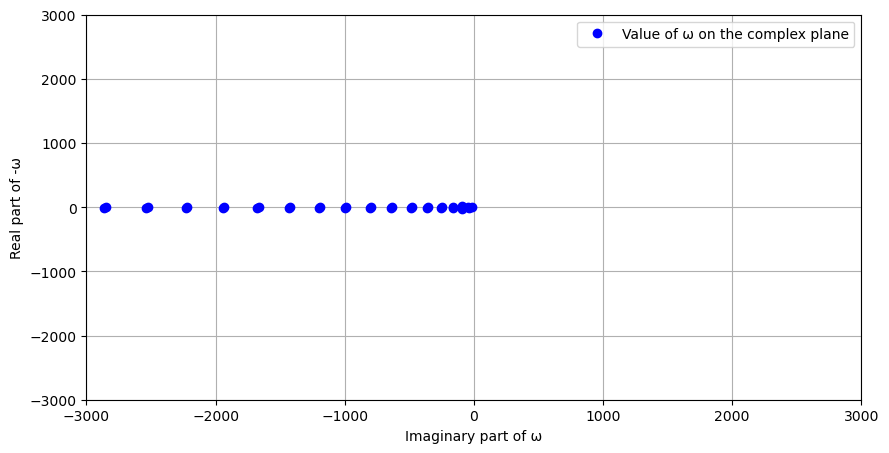

In [137]:
real_growth_rates = np.real(eigenValues)
imag_growth_rates = np.imag(eigenValues)


plt.figure(figsize=(10, 5))
plt.xlim(left = -3000, right = 3000)
plt.ylim(top = 3000, bottom = -3000)
plt.plot(real_growth_rates, imag_growth_rates, 'o', label='Value of ω on the complex plane', color='blue')
plt.xlabel('Imaginary part of ω')
plt.ylabel('Real part of -ω')
plt.grid(True)
plt.legend()
plt.show()

In [138]:
def filter(err):
    return(eigenValues[np.max(np.abs(eigenVectors), axis = 1)>err], eigenVectors[:, np.max(np.abs(eigenVectors), axis = 1)>err])

In [139]:
eigenValues, eigenVectors = filter(10**(-3))

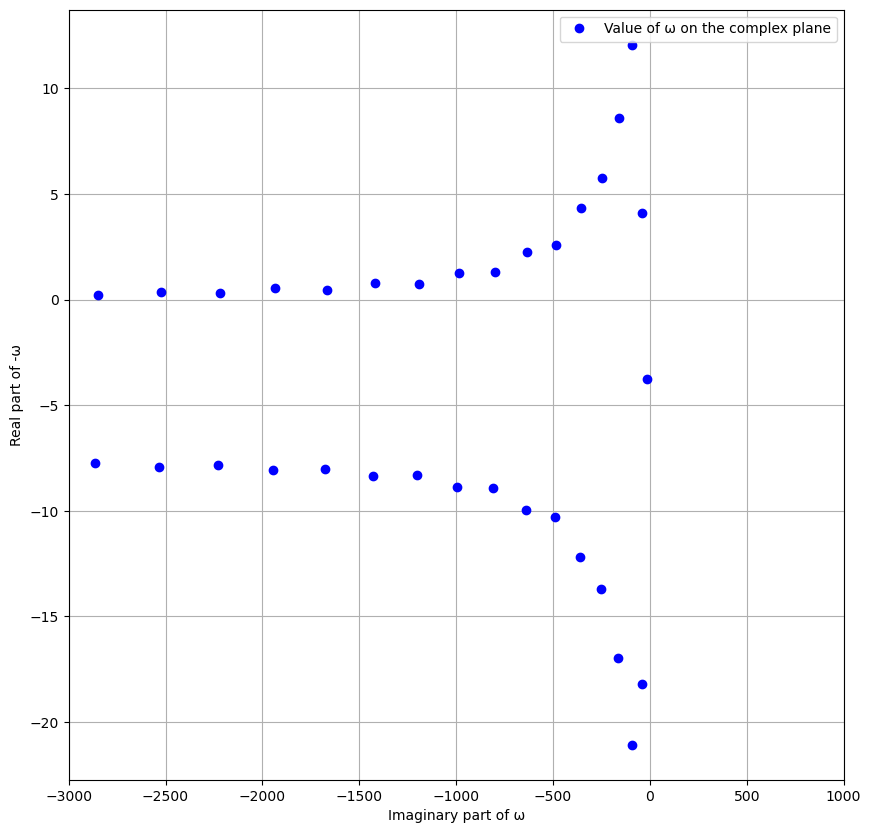

In [140]:
real_growth_rates = np.real(eigenValues)
imag_growth_rates = np.imag(eigenValues)


plt.figure(figsize=(10, 10))
plt.xlim(left = -3000, right = 1000)
plt.plot(real_growth_rates, imag_growth_rates, 'o', label='Value of ω on the complex plane', color='blue')
plt.xlabel('Imaginary part of ω')
plt.ylabel('Real part of -ω')
plt.grid(True)
plt.legend()
plt.savefig("EigenValue.jpg", dpi = 1200)
plt.show()

# Eigenmode Selection

(-17.298062935744397-3.7563635514971354j)


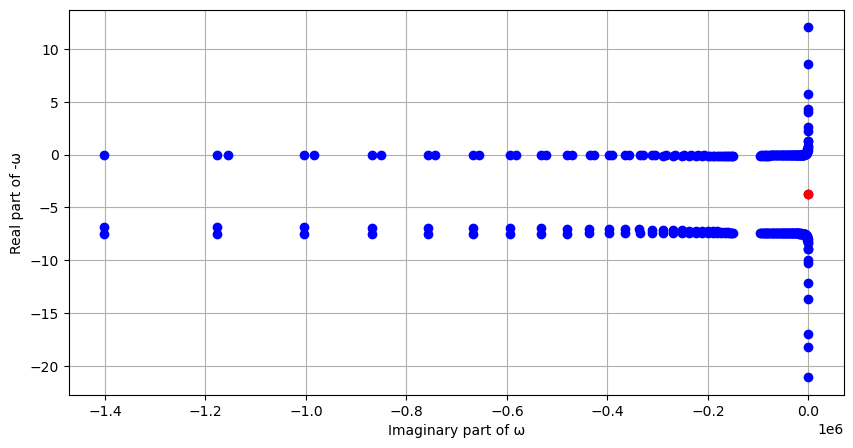

In [141]:
eigenSelection = [0, 0]

ind = np.argmin(np.abs(eigenValues - (eigenSelection[0] + 1j * eigenSelection[1])))

print(eigenValues[ind])

real_growth_rates = np.real(eigenValues)
imag_growth_rates = np.imag(eigenValues)


plt.figure(figsize=(10, 5))
plt.plot(real_growth_rates, imag_growth_rates, 'o', color='blue')
plt.plot(real_growth_rates[ind], imag_growth_rates[ind], 'o', color='red')
plt.xlabel('Imaginary part of ω')
plt.ylabel('Real part of -ω')
plt.grid(True)
plt.show()

In [142]:
def getInfoFlow(eigenvectors, r, theta, z, t, omega):
    rXi = chebyshev_matrix_scale(nbPoint)[1]
    index = np.argmin(np.abs(rXi - r))
    arrRes = eigenvectors[[index, index + nbPoint, index + 2 * nbPoint, index + 3 * nbPoint]]
    arrRes = arrRes * np.exp(1j *((- omega * t) + (m * theta) + (beta * z)))
    return np.real(arrRes), np.imag(arrRes)

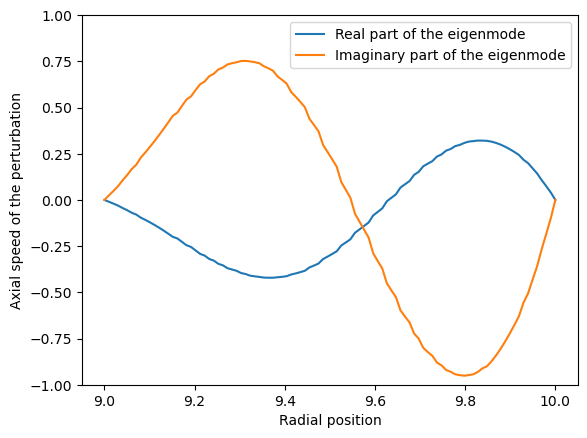

In [ ]:
r_values = np.linspace(r1, r2, 100)
evalReal = np.zeros_like(r_values, dtype=complex)
evalImag = np.zeros_like(r_values, dtype=complex)
evalRealRot = np.zeros_like(r_values, dtype=float)
evalImagRot = np.zeros_like(r_values, dtype=float)

fig, ax = plt.subplots()
line1, = ax.plot(r_values, np.zeros_like(r_values), label="Real part of the eigenmode")
line2, = ax.plot(r_values, np.zeros_like(r_values), label="Imaginary part of the eigenmode")
ax.set_ylim(-1, 1)
ax.set_xlabel('Radial position')
ax.set_ylabel('Axial speed of the perturbation')
ax.legend(loc='upper right', frameon=True)

for r in range(r_values.size):
    a, b = getInfoFlow(eigenVectors[:,ind], r_values[r], 0, 0, 0, 0)
    evalReal[r], evalImag[r] = a[2], b[2]

max = np.max(np.abs(evalReal+ 1j * evalImag))

def animate(frame):
    evalRealRot = np.real((evalReal+1j*evalImag) * np.exp(1j * 2 *np.pi * frame / 50))
    evalImagRot = np.imag((evalReal+1j*evalImag) * np.exp(1j * 2 *np.pi * frame / 50))
    line1.set_ydata(evalRealRot/ max)
    line2.set_ydata(evalImagRot/ max)
    return line1, line2

ani = FuncAnimation(fig, animate, frames=50, blit=True)

ani.save('EigenMode.mp4', writer='ffmpeg', dpi=150)
plt.show()

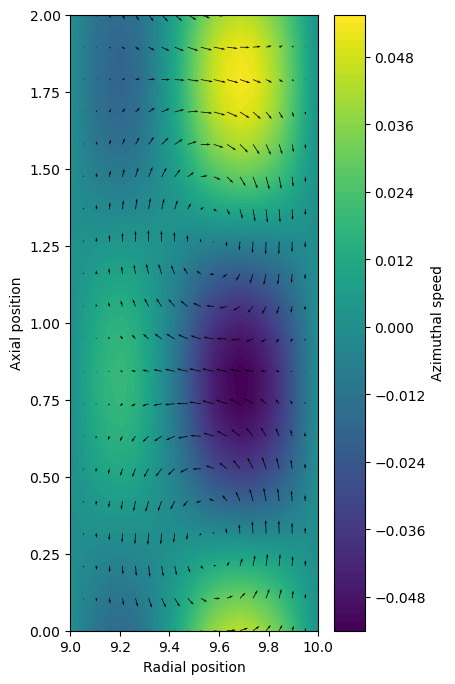

In [ ]:
r_values = np.linspace(r1, r2, 20)
z_values = np.linspace(0, 2, 20)
X, Y = np.meshgrid(r_values, z_values)

evalPressure = np.zeros_like(X)
evalUr = np.zeros_like(X)
evalUz = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        a, b = getInfoFlow(eigenVectors[:,ind], X[i, j], 0, Y[i,j], 0, eigenValues[ind])
        evalPressure[i, j] = a[1]
        evalUr[i, j] = a[0]
        evalUz[i, j] = a[2]


plt.figure(figsize=(4, 8))
plt.contourf(X, Y, evalPressure, levels=100, cmap="viridis") 
plt.colorbar(label="Azimuthal speed") 
plt.quiver(X, Y, evalUr, evalUz)
plt.xlabel("Radial position")
plt.ylabel("Axial position")
plt.savefig("EigenModeAxial.jpg", dpi = 1200)
plt.show()

In [145]:
def getRotFlow(eigenvectors, r, theta, z, t, omega):
    D, rXi = chebyshev_matrix_scale(nbPoint)
    rot = np.zeros(3 * nbPoint, complex)
    rot[0 : nbPoint] = ((1/rXi) * 1j * m) * eigenvectors[2 * nbPoint : 3 * nbPoint] - (1j * beta) * eigenvectors[nbPoint : 2 * nbPoint]
    rot[nbPoint: 2 * nbPoint] = (1j * beta) * eigenvectors[0 : nbPoint] - D @ eigenvectors[2 * nbPoint : 3 * nbPoint]
    rot[2 * nbPoint: 3 * nbPoint] = (1/rXi) * (D @ (rXi * eigenvectors[nbPoint : 2 * nbPoint]) - 1j * m * eigenvectors[0 : nbPoint])
    index = np.argmin(np.abs(rXi - r))
    arrRes = rot[[index, index + nbPoint, index + 2 * nbPoint]]
    arrRes = arrRes * np.exp(1j *((- omega * t) + (m * theta) + (beta * z)))
    return np.real(arrRes), np.imag(arrRes)

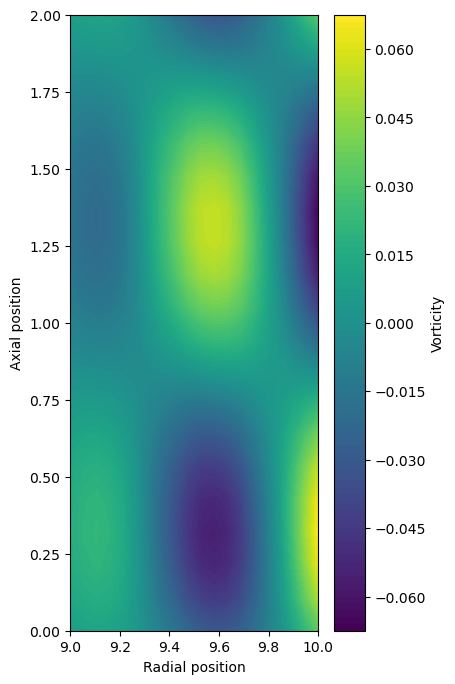

In [ ]:
r_values = np.linspace(r1, r2, 20)
z_values = np.linspace(0, 2, 20)
X, Y = np.meshgrid(r_values, z_values)

evalVortReal = np.zeros_like(X)
evalVortImag = np.zeros_like(X)
evalUr = np.zeros_like(X)
evalUz = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        a, b = getRotFlow(eigenVectors[:,ind], X[i, j], 0, Y[i,j], 0, eigenValues[ind])
        evalVortReal[i, j] = a[1]
        evalVortImag[i, j] = b[1]



plt.figure(figsize=(4, 8))
plt.contourf(X, Y, evalVortReal, levels=100, cmap="viridis")  
plt.colorbar(label = "Vorticity")
plt.xlabel("Radial position")
plt.ylabel("Axial position")
plt.savefig("EigenModeVorticity.jpg", dpi = 1200)
plt.show()

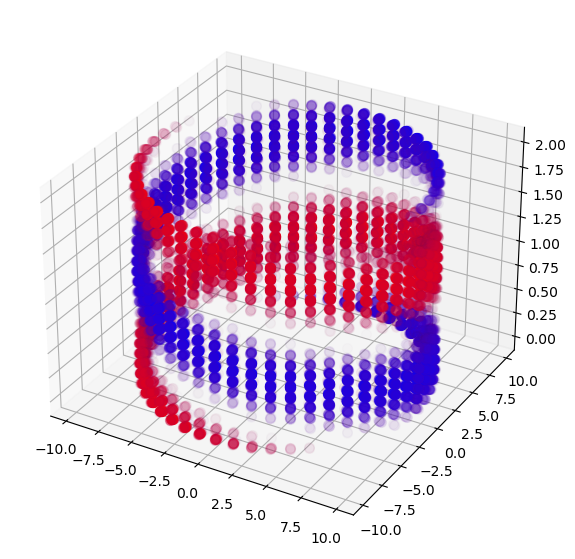

In [ ]:
nTheta = 50
Theta = np.linspace(0, np.pi*2, nTheta)

x = []
y = []
z = []
colors = []
transparencies = []

max = np.max(np.abs(evalVortReal + 1j * evalVortImag))

for theta in Theta:
    for i in range(X.shape[0]):
        for j in range(X.shape[1]-5):
            lamb = ((np.real((evalVortReal[i, j+2] + 1j * evalVortImag[i, j+2]) * np.exp(1j * m * theta)) / max) + 1) / 2
            if ((lamb>0.6) or (lamb<0.4)):
                x.append(r_values[j+2] * np.cos(theta))
                y.append(r_values[j+2] * np.sin(theta))
                z.append(z_values[i])
                colors.append(np.array([1, 0, 0]) * lamb + (1-lamb) * np.array([0, 0, 1]))
                transparencies.append(1-(lamb * (1 - lamb)))

transp = np.array(transparencies)
transp = transp - np.min(transp)
transp = 0.9 * (transp / np.max(transp)) + 0.1

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


for i in range(len(x)):
    ax.scatter(x[i], y[i], z[i], color=colors[i], alpha=(transp ** 2)[i], s=50)

plt.savefig("EigenModeVorticity3D.jpg", dpi = 1200)
plt.show()